# Import packages

In [2]:
import rasterio
import numpy as np
from scipy.ndimage import map_coordinates, gaussian_filter
from rasterio.transform import rowcol, xy
import shapefile as shp
import glob
from pyproj import Transformer
import matplotlib.pyplot as plt
from rasterio.plot import show
import pandas as pd

%matplotlib widget

# Load borehole locations

In [3]:
sf = shp.Reader("Borehole_Locations/AH_core_locations_reproj.shp")

shapes = sf.shapes()
records = sf.records()

list_of_boreholes = ['ALHIC1902', 'ALHIC1903', 'ALHIC1901', 'ALHIC2201', 'ALHIC2301']

In [4]:
borehole_locations = {}
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031")
for i in records:
    if i[0] in list_of_boreholes:
        borehole_location = transformer.transform(i[1], i[2])
        borehole_locations[i[0]] = borehole_location

# Load imagery

In [5]:
with rasterio.open('imagery/LIMA_virtual_Mosaic_15m.tif') as src1:
    image_data = src1.read()

# Load the GPS velocities

In [6]:
gps_velocities = pd.read_csv('GPS_velocities/24-25_velocities-good.csv')

# Calculate the flowline

In [7]:
# Constants
rho = 917       # kg/m^3
g = 9.81        # m/s^2

# Load surface and bed elevation rasters
with rasterio.open("DEMs/rema_100m.tif") as src:
    surface = src.read(1)[:,1:]
    transform = src.transform
    dx = transform[0]  # pixel width (x)
    dy = -transform[4] # pixel height (y)

with rasterio.open("DEMs/merged_AH_bed_topo_fix_smooth_100m.tif") as src:
    bed = src.read(1)

# Ice thickness
H = surface - bed
H[H <= 0] = np.nan

# (Optional) Smooth surface to reduce gradient noise
surface_smooth = gaussian_filter(surface, sigma=2)
bed_smooth = gaussian_filter(bed, sigma=2)

# Surface and bed slopes in radians
def slope_angle(elev):
    dzdy, dzdx = np.gradient(elev, dy, dx)
    angle = np.arctan(np.hypot(dzdx, dzdy))
    return dzdx, dzdy, angle

bed_dx, bed_dy, theta_b = slope_angle(bed_smooth)
surf_dx, surf_dy, theta_s = slope_angle(surface_smooth)

# Driving stress from Cuffey & Paterson Figure 8.5
tau_d = rho * g * H * (np.sin(theta_b) - np.tan(theta_b - theta_s))

# Flow direction (unit vector downslope of surface)
mag = np.hypot(surf_dx, surf_dy)
ux = -surf_dx / (mag )
uy = -surf_dy / (mag )

# Stress-weighted pseudo-velocity
vx = ux * tau_d
vy = uy * tau_d

# Helper: trace flowline in given field
def trace_flowline(start_rc, vx, vy, max_steps=500, step_size=4):
    r, c = float(start_rc[0]), float(start_rc[1])
    coords = []
    for _ in range(max_steps):
        if not (0 <= r < surface.shape[0] and 0 <= c < surface.shape[1]):
            break
        if np.isnan(H[int(r), int(c)]) or H[int(r), int(c)] <= 0:
            break
        x, y = xy(transform, r, c)
        coords.append((x, y))

        vx_r = map_coordinates(vx, [[r], [c]], order=1)[0]
        vy_r = map_coordinates(vy, [[r], [c]], order=1)[0]
        vmag = np.hypot(vx_r, vy_r)
        if vmag < 1e-4:
            break

        dr = vy_r / vmag
        dc = vx_r / vmag
        r += step_size * dr
        c += step_size * dc
    return coords

flowlines_all = {}

for i in borehole_locations:
    # Control point in map coordinates
    borehole_location = borehole_locations[i]
    x0, y0 = borehole_location  # <-- Change to your point
    r0, c0 = rowcol(transform, x0, y0)

    # Trace downstream and upstream
    flow_down = trace_flowline((r0, c0), vx, vy)
    flow_up = trace_flowline((r0, c0), -vx, -vy)

    # Combine full flowline
    full_flowline = list(reversed(flow_up)) + flow_down[1:]

    flowlines_all[i] = full_flowline

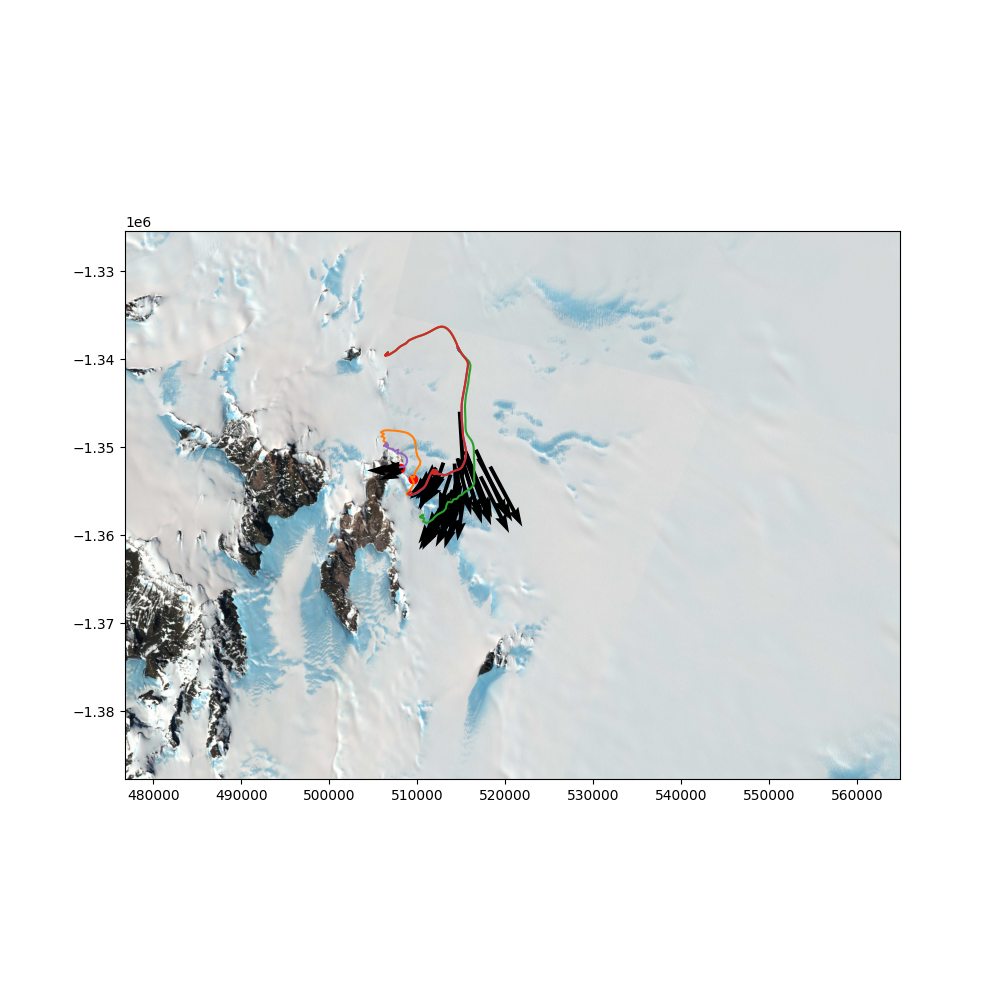

In [9]:
fig,ax = plt.subplots(figsize=[10,10])

## LIMA basemap image
show(image_data, transform=src1.transform, ax=ax)

## Flowline
for i in flowlines_all:
    full_flowline = flowlines_all[i]
    ax.plot(np.array(full_flowline)[:,0], np.array(full_flowline)[:,1])

## Borehole location
for i in borehole_locations:
    borehole_location = borehole_locations[i]
    ax.scatter(borehole_location[0], borehole_location[1], c='red')

## GPS velocities
## GPS velocity vectors
quiver = ax.quiver(gps_velocities['x'],gps_velocities['y'], 
                   gps_velocities['u'], gps_velocities['v'], 
                   scale = 1/0.2, label= "GPS velocity", 
                   width=5e-3)

# Extract the profiles

In [199]:
# Function to sample any raster at (row, col)
def sample_raster(raster_array, rows, cols):
    return map_coordinates(raster_array, [rows, cols], order=1, mode='nearest')

In [202]:
for i in flowlines_all:
    full_flowline = flowlines_all[i]
    # Convert flowline (x, y) to raster (row, col)
    rows_cols = [rowcol(transform, x, y) for x, y in full_flowline]
    rows, cols = zip(*rows_cols)
    rows = np.array(rows).astype(float)
    cols = np.array(cols).astype(float)

    # Sample along flowline
    surf_vals = sample_raster(surface, rows, cols)
    bed_vals = sample_raster(bed, rows, cols)
    thickness_vals = surf_vals - bed_vals
    stress_vals = sample_raster(tau_d, rows, cols)
    slope_vals = sample_raster(np.arctan(mag), rows, cols)  # surface slope angle in radians

    # Convert flowline (x, y) to raster (row, col)
    rows_cols = [rowcol(transform, x, y) for x, y in full_flowline]
    rows, cols = zip(*rows_cols)
    rows = np.array(rows).astype(float)
    cols = np.array(cols).astype(float)

    # Function to sample any raster at (row, col)
    def sample_raster(raster_array, rows, cols):
        return map_coordinates(raster_array, [rows, cols], order=1, mode='nearest')

    # Sample along flowline
    surf_vals = sample_raster(surface, rows, cols)
    bed_vals = sample_raster(bed, rows, cols)
    thickness_vals = surf_vals - bed_vals
    stress_vals = sample_raster(tau_d, rows, cols)
    slope_vals = sample_raster(np.arctan(mag), rows, cols)  # surface slope angle in radians
    # Extract coordinates
    x_coords = np.array([x for x, y in full_flowline])
    y_coords = np.array([y for x, y in full_flowline])

    # Compute pairwise distances
    dx = np.diff(x_coords)
    dy = np.diff(y_coords)
    segment_lengths = np.hypot(dx, dy)

    # Cumulative distance: start at 0
    distance_along = np.insert(np.cumsum(segment_lengths), 0, 0)
    flowline_data_surf = pd.DataFrame({
        'Distance': distance_along,
        'E': [x for x, y in full_flowline],
        'N': [y for x, y in full_flowline],
        'Elev': surf_vals
    })

    flowline_data_bed = pd.DataFrame({
        'Distance': distance_along,
        'E': [x for x, y in full_flowline],
        'N': [y for x, y in full_flowline],
        'Elev': bed_vals
    })
    flowline_data_surf.to_csv(f'flowline_csv/{i}_flowline_surf.csv', index=False)
    flowline_data_bed.to_csv(f'flowline_csv/{i}_flowline_bed.csv', index=False)
